# 01 - PyTorch Workflow

1. Data(prepare and Load)
2. Build Model
3. Fitting the model to data(training).
4. Make predictions and evaluate a model(inference).
5. Saving and Loading a model.
6. Putting it all together.

In [169]:
import torch
from torch import nn # nn contains all the PyTorch's basic building blocks neural networks
import matplotlib.pyplot as plt
import numpy as np
# Check PyTorch Version
torch.__version__

'2.3.1+cu121'

## 1. Data (Preparing and Loading)

* Get data into a numerical representation.
* Build a model to learn patterns in that numerical representation.

In [129]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim =1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [130]:
len(X), len(y)

(50, 50)

### Splitting Data into training and test sets

In [131]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize Data

In [132]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="pink", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")

  plt.legend(prop={"size": 14})

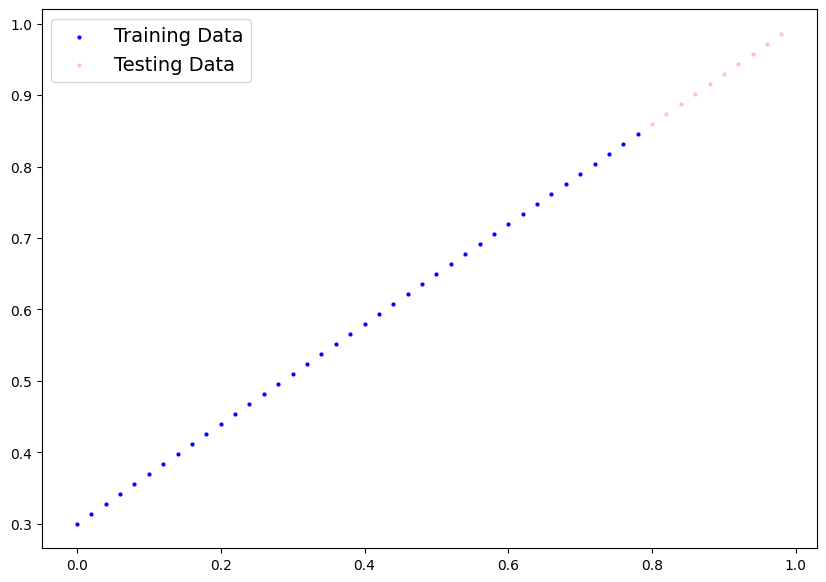

In [133]:
plot_predictions()

## 2. Build Model
1. Start with random values (weights and bias)
2. Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias) values we used to create the data.

* Gradient Descent
* Backpropagation

In [134]:
from torch import nn

# Create a linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # Linear Regression

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs (another word for neural networks)
* torch.nn.parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.module - The base class for all neural network module, if you subclass it you should overwrite forward().
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

In [135]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

### Checking the contents of our PyTorch models.

What's inside a model.
Check model's parameters using '.parameters'

In [156]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check moddel parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [157]:
# List name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [158]:
weight, bias

(0.7, 0.3)

### Making predictions using torch.inference_mode()

To check our model's predictive power, let's see how well it predicts 'y_test' based on 'X_test'.

When we pass data through our model it is going to run it through the forward() method.

In [159]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

In [160]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [161]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

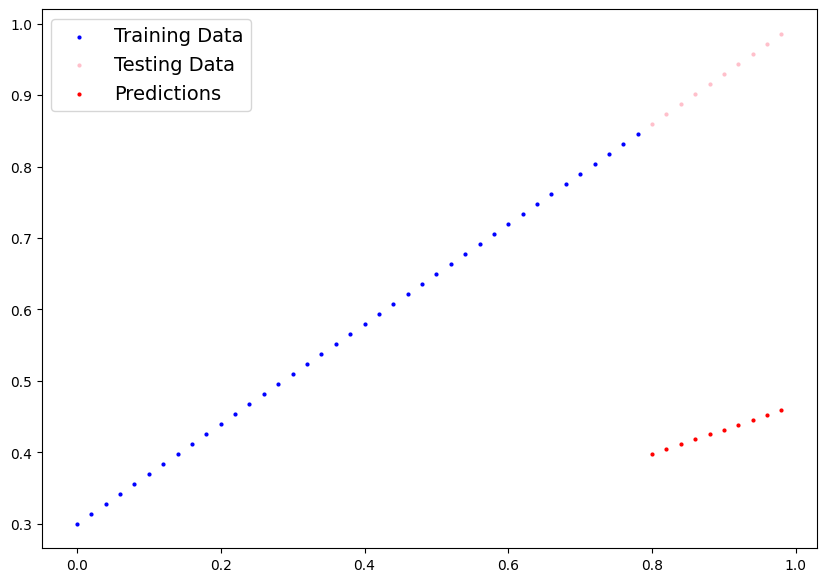

In [162]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training os for the model to move from ssome *unknown* parameters (maybe random) to some *known* parameters.

From a poor representation of data to a better representation of data.

One way to measure how poor or wrong your models predictions are is to use a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's prediction are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g weights and biases) to improve the loss function.



In [163]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [164]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [165]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #learning rate

### Building a training and testing loop in PyTorch

Things we need in a training loop:
0. Loop through the data.
1. Forward pass (this involves data moving through our models forward() function) - **forward propagation** - to make predictions on data.
2. Calculate the loss (compare forward pass predictions to ground truth labels).
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss. (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to minimize loss. (**gradient descent**)


In [166]:
# An epoch is one loop through the data... (hyperparameters: we set it ourself)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop though the data
for epoch  in range(epochs):
  # Set the model to training mode
  model_0.train() # Train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the los w.r.t to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so.. we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # Turns off different settings in the model not needed for evaluation/testing (dropout/bach_norm_layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple of more things. may also see torch.no_grad() in older code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(f"{model_0.state_dict()}\n")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])

Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])

Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])

Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])

Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])

Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])

Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([

In [172]:
np.array(torch.tensor(loss_values).cpu().numpy()), test_loss_values

(array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
        0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
        0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

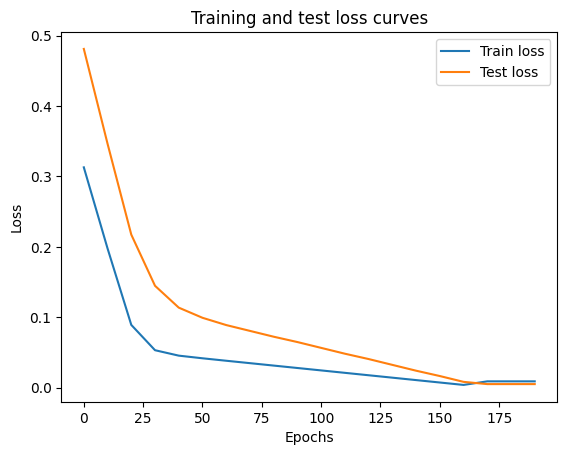

In [174]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [154]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

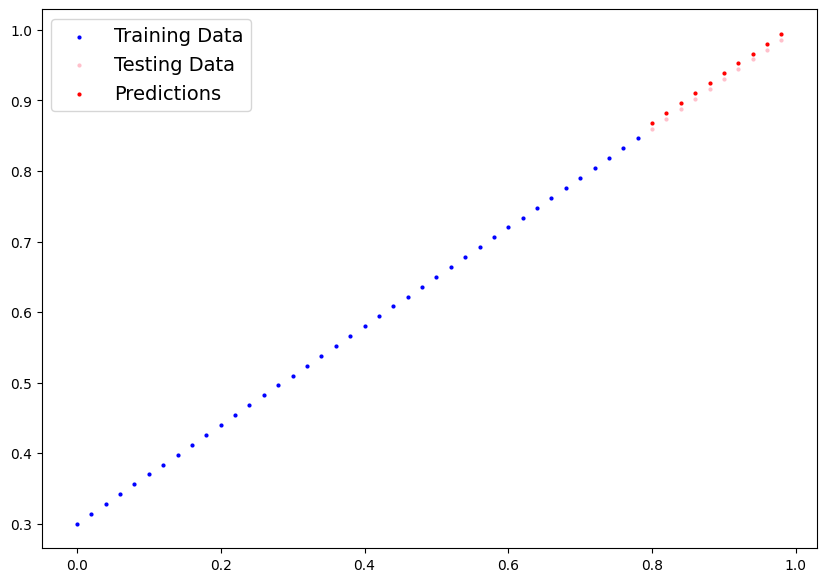

In [155]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

Three methods to save and load model in PyTorch.

1. 'torch.save()' - allows to save a PyTorch object in python's pickle format.

2. 'torch.load()' - allows to load a saved PyTorch object.

3. 'torch.nn.Module.load_state_dict()' - this allows to load a model's saved state dictionary.

In [175]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [177]:
# Saving our PyTorch model
from pathlib import Path

In [179]:
# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [180]:
# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [181]:
# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [182]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Jul 30 12:46 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model



In [184]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [185]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

In [187]:
# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [188]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [189]:
# Make predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [190]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all together

In [191]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [192]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cpu


### Data

In [193]:
weight = 0.7
bias = 0.3

start = 0
end =1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [194]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

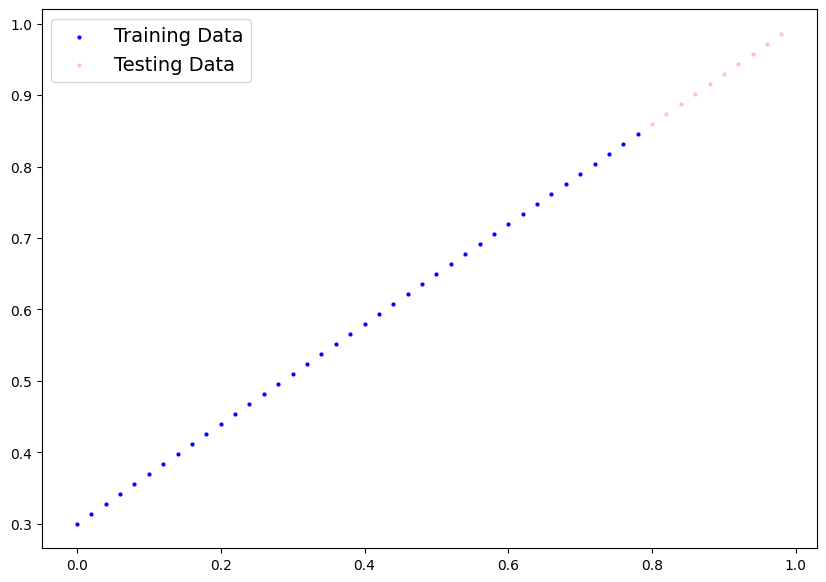

In [195]:
plot_predictions(X_train, y_train, X_test, y_test)

### Build Model

In [197]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [199]:
next(model_1.parameters()).device

device(type='cpu')

In [200]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### Training

In [202]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01, )

In [203]:
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  model_1.train()

  y_pred = model_1(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test Loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.01380180753767

In [204]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

### Predictions

In [205]:
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

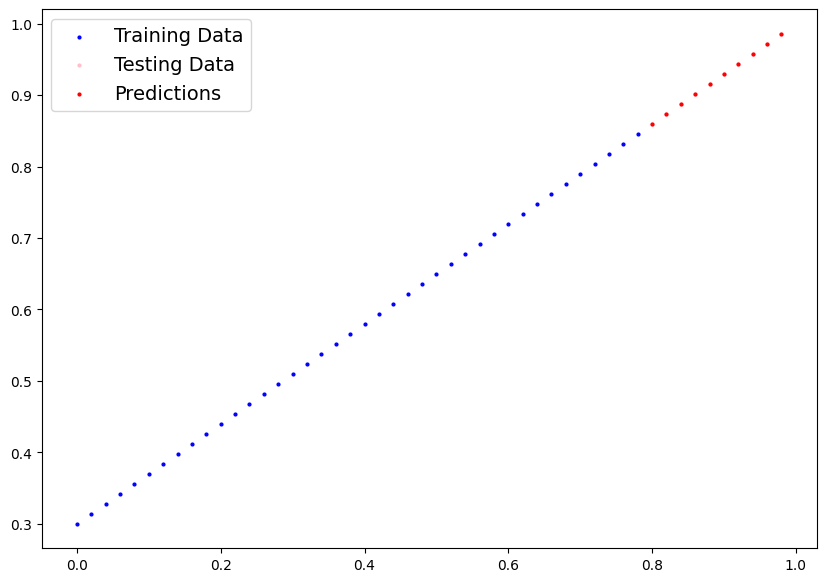

In [206]:
plot_predictions(predictions=y_preds)

### Saving and Loading Trained Model

In [209]:
from pathlib import PurePath

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [210]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [212]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [214]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [215]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [216]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])